
### Homework: Clustering Analysis on a Customers Dataset
Consider that you possess a dataset of customer information, and your task is to perform customer segmentation on this historical data. Customer segmentation involves dividing a customer base into distinct groups based on shared characteristics. This approach is crucial because it allows a business to target specific groups effectively and optimize the allocation of marketing resources. For instance, one segment might consist of high-profit, low-risk customers—those more likely to make purchases or subscribe to services, whom the business aims to retain. Another segment could be customers from non-profit organizations, among others.

In this assignment, you will perform clustering analysis on the Mall Customers Dataset. This dataset includes the `Age`, `Annual Income`, and `Spending Score` of customers. You will use K-Means and DBSCAN clustering algorithms to segment customers based on their behaviors and traits. The primary objective is to understand customer segments to tailor marketing strategies effectively.

---

#### Step 1: Data Loading and Initial Exploration

**Exercise 1:**
- Load the Mall Customers dataset from the following URL: 'https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/Cust_Segmentation.csv'.
- Use pandas to read the data and display the first few rows. 
- Generate basic statistics of the data using `.describe()`.


In [177]:
import pandas as pd
import io
import requests

# Load the data
url = 'https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/Cust_Segmentation.csv'

s = requests.get(url).content
mall_customers = pd.read_csv(io.StringIO(s.decode('utf-8')))
# Write your code here
mall_customers.head(25) # checked the rows
# mall_customers.info()
mall_customers_noNaN = mall_customers.dropna()
mall_customers_noNaN.info()
mall_customers_noNaN.describe()
# mall_customers_noNaN


<class 'pandas.core.frame.DataFrame'>
Index: 700 entries, 0 to 849
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Customer Id      700 non-null    int64  
 1   Age              700 non-null    int64  
 2   Edu              700 non-null    int64  
 3   Years Employed   700 non-null    int64  
 4   Income           700 non-null    int64  
 5   Card Debt        700 non-null    float64
 6   Other Debt       700 non-null    float64
 7   Defaulted        700 non-null    float64
 8   Address          700 non-null    object 
 9   DebtIncomeRatio  700 non-null    float64
dtypes: float64(4), int64(5), object(1)
memory usage: 60.2+ KB


,Customer Id,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
count,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000
mean,430.461429,34.860000,1.722857,8.388571,45.601429,1.553566,3.058196,0.261429,10.260571
std,243.323524,7.997342,0.928206,6.658039,36.814226,2.117196,3.287550,0.439727,6.827234
min,1.000000,20.000000,1.000000,0.000000,14.000000,0.012000,0.046000,0.000000,0.400000
25%,222.750000,29.000000,1.000000,3.000000,24.000000,0.368750,1.044000,0.000000,5.000000
50%,433.500000,34.000000,1.000000,7.000000,34.000000,0.855000,1.987500,0.000000,8.600000
75%,642.250000,40.000000,2.000000,12.000000,55.000000,1.901750,3.923250,1.000000,14.125000
max,850.000000,56.000000,5.000000,31.000000,446.000000,20.561000,27.034000,1.000000,41.300000


#### Step 2: Data Preprocessing

**Exercise 2:**
- As observed, the "Address" field in this dataset is a categorical variable. The k-means algorithm, which relies on Euclidean distance, isn't suitable for categorical data because this type of distance measure doesn't make sense for discrete variables. Therefore, exclude this feature and proceed with the clustering analysis.
- Now  normalize the dataset. But why do we need normalization in the first place? Normalization is a statistical method that helps mathematical-based algorithms to interpret features with different magnitudes and distributions equally. We use __StandardScaler()__ to normalize our dataset.





In [178]:
from sklearn.preprocessing import StandardScaler

# Write your code here
data_standardized = StandardScaler().fit_transform(mall_customers_noNaN.drop(columns=['Customer Id', 'Address', 'Defaulted']))
data_standardized = pd.DataFrame(data_standardized)
data_standardized.columns = mall_customers_noNaN.drop(columns=['Customer Id', 'Address', 'Defaulted']).columns
data_standardized.describe()
data_standardized



,Age,Edu,Years Employed,Income,Card Debt,Other Debt,DebtIncomeRatio
0,0.768304,0.298793,-0.359007,-0.723102,-0.675699,-0.604284,-0.580528
1,1.519090,-0.779325,2.647029,1.478707,1.431421,1.570620,0.372222
2,-0.232744,0.298793,0.242201,0.309845,2.154119,0.835201,1.559495
3,-0.733267,0.298793,-0.659610,-0.723102,-0.412427,-0.773833,-0.580528
4,1.519090,-0.779325,3.398538,5.637681,3.665215,1.780653,-0.448609
...,...,...,...,...,...,...,...
695,0.768304,-0.779325,-0.208705,-0.070714,-0.406283,-0.566235,-0.859025
696,-0.858398,0.298793,-0.208705,-0.315360,-0.564624,-0.315718,-0.477925
697,-1.233791,2.455029,-1.260817,-0.750285,0.590086,0.046209,3.391707
698,-0.357875,-0.779325,0.542804,-0.478457,-0.679481,-0.719041,-1.078890


#### Step 3: Applying K-Means Clustering

**Exercise 3:**
- Apply K-Means clustering on the processed data. Choose a suitable number of clusters (start with `k=3`).
- Fit the model and then predict the cluster labels.
- Add these labels as a new column in the DataFrame and create a new DataFrame.
- Calculate the centroid value of each class.



In [179]:
from sklearn.cluster import KMeans

# Write your code 
k = 3
k_means_datastand = KMeans(init = "k-means++", n_clusters = k, n_init = 12)

k_means_datastand.fit(data_standardized)

k_means_labels_datastand = k_means_datastand.labels_
print("k-means assigned labels: ", k_means_labels_datastand)

clustered_df = data_standardized.copy()
clustered_df['Cluster'] = k_means_labels_datastand
clustered_df

k_means_cluster_centers_datastand = k_means_datastand.cluster_centers_
print("k-means assigned cluster centers: ")
print(k_means_cluster_centers_datastand)

centroids_df = pd.DataFrame(k_means_cluster_centers_datastand, columns=data_standardized.columns)
centroids_df['Cluster'] = range(k)
centroids_df

k-means assigned labels:  [2 0 0 1 0 2 2 2 2 1 1 1 1 1 2 1 2 0 1 2 2 2 2 1 1 1 1 1 1 0 1 0 2 1 1 2 0
 1 0 1 1 1 2 2 2 2 2 0 1 1 2 1 1 1 1 2 2 1 1 2 1 0 2 0 0 2 1 1 2 1 1 1 1 2
 1 1 1 2 2 1 0 2 1 2 2 1 1 1 2 1 0 1 1 1 1 2 2 1 1 1 1 2 2 1 1 1 1 2 2 2 1
 1 1 0 1 2 1 1 2 1 2 2 2 1 1 2 2 2 1 1 1 1 1 2 0 1 1 1 2 2 2 1 1 2 1 2 1 0
 1 0 2 2 2 1 2 1 2 0 1 0 1 2 2 1 0 2 1 1 2 2 1 2 2 1 2 1 1 1 1 0 1 1 2 2 2
 1 0 1 1 0 1 1 2 1 2 2 1 1 1 2 1 2 1 2 1 1 1 2 1 0 2 0 1 2 1 1 2 1 1 2 1 1
 2 1 0 2 1 2 0 1 1 0 1 1 1 1 1 0 2 2 1 1 1 2 2 1 2 1 1 1 2 1 1 0 1 0 1 2 1
 1 2 2 2 0 1 2 2 2 1 0 2 2 2 2 0 2 1 1 1 1 0 1 2 1 1 2 0 1 1 0 1 1 1 2 1 2
 2 0 2 1 1 2 2 1 1 2 1 2 1 1 2 0 2 2 1 1 1 1 0 2 0 1 2 2 1 1 1 1 1 0 2 0 1
 2 1 1 1 2 1 0 2 0 1 2 2 2 1 1 0 1 1 0 1 1 1 0 2 2 2 1 0 1 2 2 2 2 0 1 1 1
 0 1 1 1 2 2 0 1 1 1 2 2 1 2 0 0 2 2 2 1 2 1 1 1 1 2 1 2 1 2 0 1 1 1 0 2 2
 1 1 0 1 1 1 1 1 2 1 2 1 1 1 1 0 2 1 1 1 0 0 1 1 1 1 2 1 1 1 0 1 1 1 1 2 2
 1 2 2 2 2 1 2 1 0 1 2 2 1 1 2 1 2 1 2 1 0 1 1 0 2 1 2 1 1 1 1 2 0 1 2 2 0

,Age,Edu,Years Employed,Income,Card Debt,Other Debt,DebtIncomeRatio,Cluster
0,0.810931,0.358030,1.150618,1.475123,1.679018,1.963682,1.059845,0
1,-0.700699,0.027048,-0.637785,-0.502214,-0.326671,-0.385767,-0.038194,1
2,0.745739,-0.173989,0.524940,0.201114,-0.137523,-0.155287,-0.338136,2


**Exercise 4:**
- Plot the results using a scatter plot. Use `Age` as the x-axis and `Income` as the y-axis. Color the points based on the cluster labels.
- Interpret the plot. What does each cluster seem to represent in terms of customer behavior?


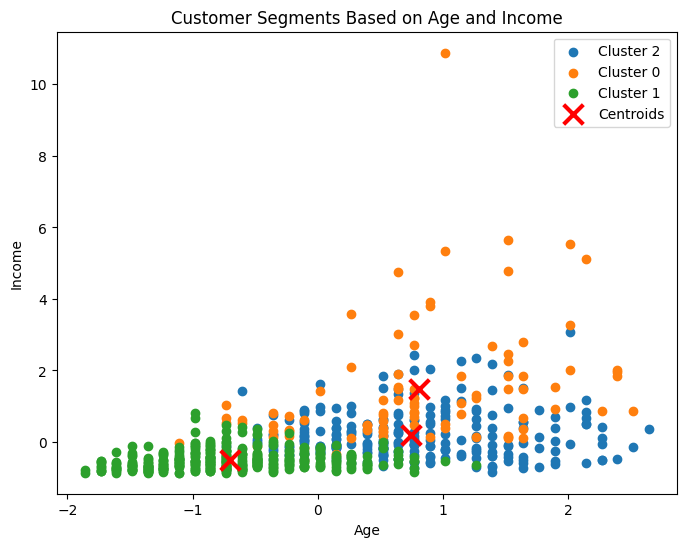

In [181]:
import matplotlib.pyplot as plt

# Write your code here

plt.figure(figsize=(8, 6))

for cluster in clustered_df['Cluster'].unique():
    cluster_data = clustered_df[clustered_df['Cluster'] == cluster]
    plt.scatter(cluster_data['Age'], cluster_data['Income'], label=f'Cluster {cluster}')

centroids = pd.DataFrame(k_means_cluster_centers_datastand, columns=data_standardized.columns)
plt.scatter(centroids['Age'], centroids['Income'], c='red', marker='x', s=200, linewidths=3, label='Centroids')

plt.xlabel('Age')
plt.ylabel('Income')
plt.title('Customer Segments Based on Age and Income')
plt.legend()

plt.show()

# The segmentation shows us old-high income customers (cluster 2) as we as young-low income customers (cluster 1). 
# The third  seems to be somewhere in between, medium/old aged - medium income customers (cluster 0)

#### Step 4: Applying DBSCAN Clustering

**Exercise 5:**
- Apply DBSCAN to the same dataset. Start with `eps=0.5` and `min_samples=5`.
- Fit the model and then predict the cluster labels.
- Determine the count of predicted classes. Adjust 'eps' and 'min_samples' to attain a total of three classes.
- Add these labels as a new column in your DataFrame and create a new DataFrame.

In [183]:
from sklearn.cluster import DBSCAN
import numpy as np

# Write your code here
dbscan = DBSCAN(eps=0.5, min_samples=5) 
dbscan_labels = dbscan.fit_predict(data_standardized)
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)  # '-1' is the label for noise
n_noise = list(dbscan_labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters)
print("Estimated number of noise points: %d" % n_noise)

eps = 0.9  # adjustable value
min_samples = 10  # adjustable value

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(data_standardized)

n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print("After tuning:")
print("Estimated number of clusters: %d" % n_clusters)
print("Estimated number of noise points: %d" % n_noise)

final_clustered_df_dbscan = data_standardized.copy()
final_clustered_df_dbscan['DBSCAN_Cluster'] = dbscan_labels

print(final_clustered_df_dbscan.head())

Estimated number of clusters: 5
Estimated number of noise points: 534
After tuning:
Estimated number of clusters: 3
Estimated number of noise points: 307
        Age       Edu  Years Employed    Income  Card Debt  Other Debt  \
0  0.768304  0.298793       -0.359007 -0.723102  -0.675699   -0.604284   
1  1.519090 -0.779325        2.647029  1.478707   1.431421    1.570620   
2 -0.232744  0.298793        0.242201  0.309845   2.154119    0.835201   
3 -0.733267  0.298793       -0.659610 -0.723102  -0.412427   -0.773833   
4  1.519090 -0.779325        3.398538  5.637681   3.665215    1.780653   

   DebtIncomeRatio  DBSCAN_Cluster  
0        -0.580528               0  
1         0.372222              -1  
2         1.559495              -1  
3        -0.580528               0  
4        -0.448609              -1  


**Exercise 6:**
- Plot the results using the same scatter plot setup as in Exercise 4.
- Compare the results with K-Means. How does DBSCAN differ in terms of cluster formation?

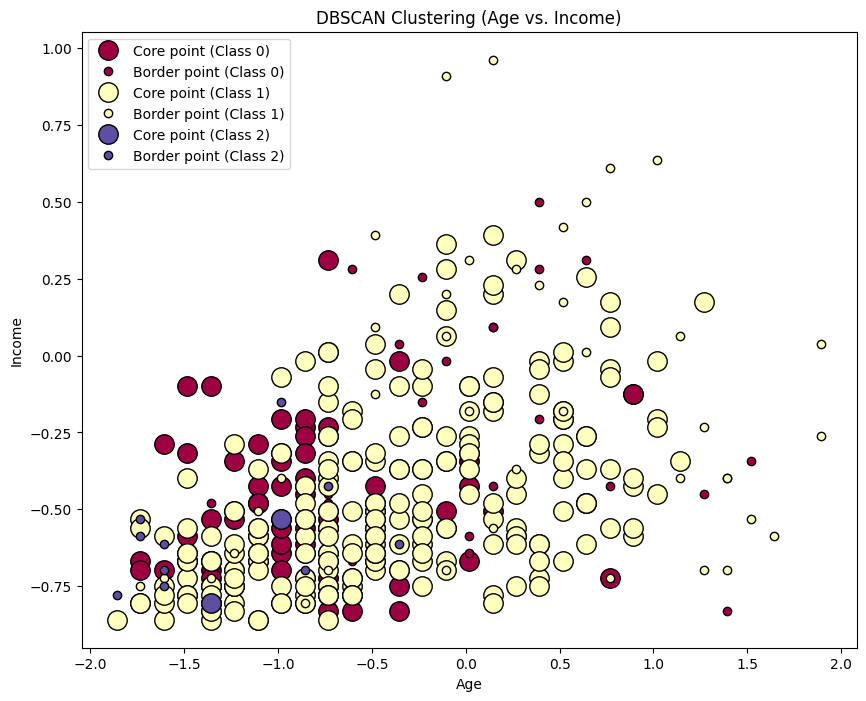

In [184]:
# Write your code here
core_samples_mask = np.zeros_like(dbscan_labels, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True

unique_labels = set(dbscan_labels)
unique_labels.discard(-1)  # Remove noise (-1) from the set of labels

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1)

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    class_member_mask = (dbscan_labels == k)

    xy_core = data_standardized[class_member_mask & core_samples_mask]

    ax.plot(
        xy_core['Age'], xy_core['Income'], "o", markerfacecolor=tuple(col),
        markeredgecolor="k", markersize=14, label=f'Core point (Class {k})'
    )

    xy_border = data_standardized[class_member_mask & ~core_samples_mask]

    ax.plot(
        xy_border['Age'], xy_border['Income'], "o", markerfacecolor=tuple(col),
        markeredgecolor="k", markersize=6, label=f'Border point (Class {k})'
    )

ax.set_xlabel('Age')
ax.set_ylabel('Income')
ax.set_title('DBSCAN Clustering (Age vs. Income)')

ax.legend()
plt.show()

# the dataset seems to be really noisy since with all the noise included, the figure was unreadable, thus for the sake of presentation i discarded the noise
# the noise is most likely the reason of the many nr. of attributes. in the future i could probably drop or limit the nr. of attributes to make the database a lot clearer
# the clusters does not seems as well defined as with K-Means, class 1 seems to represent almost the whole dataset, while class 0 sort of stands for younger customers w exceptions)
# while class 2 stands for a certain low income young customers (w exceptions)
# the clusters do not make much sense, but with different eps and min_sample values they seemed to be even worse, so I sticked with these

#### Step 5: Evaluation and Interpretation

**Exercise 7:**
- Calculate and compare the silhouette scores for both K-Means and DBSCAN.
- Discuss the strengths and weaknesses of each clustering method based on the dataset and the results obtained.

In [185]:
from sklearn.metrics import silhouette_score
k_means_silhouette_score = silhouette_score(data_standardized, k_means_labels_datastand)
print(f"Silhouette Score for K-Means: {k_means_silhouette_score}")
dbscan_silhouette_score = silhouette_score(data_standardized, dbscan_labels)
print(f"Silhouette Score for DBSCAN: {dbscan_silhouette_score}")

# After seeing the silhouette scores of 0.21392390237754516 (K-Means) and 0.007928515568099455 (DBSCAN), I can say the following:
# K-means: the score indicates that, on average, the clusters are somewhat well-defined but there's considerable overlap between them. Clusters are not highly distinct
# Poor Cohesion and Separation: Suggests that the clusters are barely distinguishable from each other, with almost no clear separation. 
# This score for DBSCAN is close to 0, implying that data points are on the boundary of clusters or that the clustering structure is not well-defined.
# It was probably due to the randomly guessed eps and min_sample, that I personally do not fully understand how they work, and how they help definying the data

Silhouette Score for K-Means: 0.20750709233567347
Silhouette Score for DBSCAN: 0.007928515568099455




#### Submission Instructions
Please submit your finished Jupyter Notebook with all exercises fully completed. Make sure to include comments in your code cells to clarify your thought process and results. Below each corresponding exercise, add your discussions in a "Markdown" section within this file.
